### Comparison of different methods

The various codes that were used for calculation are-  
* code 1 : The FAST cluster calculation code called as subprocess from python
* code 2 : Steinhardt module called as library from python
* code 3 : Traj files read in through python and passed to steinhardt module called as library
* code 4 : Traj files read in through memory mapped file and passed to steinhardt module called as library
* code 5 : Python is used to split files which are read in through c++.
  
They were tested on three different types of trajectories-  
* traj 1 : short 10 slice, 500 atom per snapshot trajectory
* traj 2 : long 10000 slice, 500 atom per snapshot trajectory

### Performance for traj 1

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
%matplotlib inline

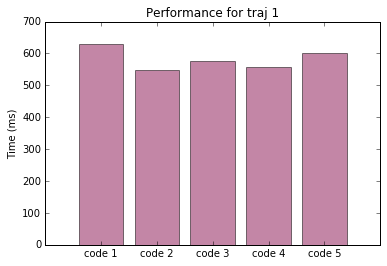

In [7]:
objects = ('code 1', 'code 2', 'code 3', 'code 4', 'code 5')
y_pos = np.arange(len(objects))
performance = [629,548,575,559,600]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color='#880E4F')
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Performance for traj 1')

### Performance of traj 2

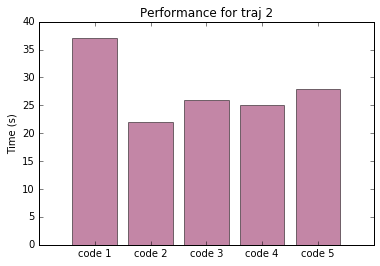

In [8]:
objects = ('code 1', 'code 2', 'code 3', 'code 4', 'code 5')
y_pos = np.arange(len(objects))
performance = [37,22,26,25,28]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color='#880E4F')
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Performance for traj 2')

## Implementing 'lazy' calculation with Dask

Dask is a python library which provides laptop-cluster scalable easy calculations. Dask also allows lazy objects, which prepare the recipe for calculations and then iplement it. Dask will show a lower memory footprint because of the delayed reading. It reads in just enough of the data.

In [40]:
import steinhardt as st
import os
import sys
import subprocess as sub
from dask import delayed

In [41]:
# function to read a file and calculate nucsize

def getQTrajectory(filename):
        #create Steinhardt system objects
        sys = st.System()
        #set inout file and read it
        sys.set_inputfile(filename)
        sys.read_particle_file()
        #set nucsize parameters
        sys.set_neighbordistance(3.63)
        sys.set_nucsize_parameters(7,0.5,0.5)
        #now calculate nucsize
        nuc = sys.calculate_nucsize()
        return nuc

In [42]:
#function to calculate nucsuze over a traj

def calculate_nuctraj(trajname,nop):
    x = []
    filename = trajname
    natoms=nop
    nblock = natoms+9
    startblock = 0
    count=1
    files = []
    #convert file to snaps
    with open(filename) as infile:
        for line in infile:
            if(count==1):
                ff = 'snap.'+str(startblock)+'.dat'
                files.append(ff)
                fout = open(ff,'w')
                fout.write(line)
                #count+=1
            elif(count<nblock):
                fout.write(line)
                #count+=1

            else:
                fout.close()
                count=0
                startblock+=1
            count+=1
    for ff in files:
        x.append(delayed (getQTrajectory)(ff))
    return x

## How the  Dask object works

First, run the function above, as we can see it returns a delayed list

In [47]:
%%timeit
delayed_traj = calculate_nuctraj('traj.light',500)
delayed_traj

10 loops, best of 3: 33.9 ms per loop


The calculation did not really happen yet. It just returned a delayed object.

In [48]:
%%timeit
nucs = []
for i in range(len(delayed_traj)):
    nucs.append(delayed_traj[i].compute())

1 loop, best of 3: 761 ms per loop


The calculation is completed now, and it gave faster results that any of the code we tested. Now testing with the longer trajectory.

In [49]:
delayed_traj = calculate_nuctraj('traj.long',500)
delayed_traj

[Delayed('getQTrajectory-1ca720bb-5951-44d7-9324-1c4fff338351'),
 Delayed('getQTrajectory-75d10c60-f3e5-403b-9626-e0384fba94b9'),
 Delayed('getQTrajectory-01a5701a-89ff-4412-89ff-adc11231a480'),
 Delayed('getQTrajectory-15c6a65e-3d97-43fb-b31e-cbe855ab759f'),
 Delayed('getQTrajectory-f4fa0c0d-e605-49b4-ac13-11ece9cbec43'),
 Delayed('getQTrajectory-221fbb54-507d-4f56-bba7-c374fa1eb701'),
 Delayed('getQTrajectory-9dfdc600-212d-4d90-9242-f37162111571'),
 Delayed('getQTrajectory-45bb4837-65d9-4114-a7a4-731123225eb7'),
 Delayed('getQTrajectory-1427784b-c005-451e-b06c-c8c21458f34f'),
 Delayed('getQTrajectory-c2a102a0-e6db-4d4c-b5a4-2cbbd1cf9f32'),
 Delayed('getQTrajectory-094011ee-9dde-48f1-8d79-7c3c39a2a5da'),
 Delayed('getQTrajectory-e6838606-0e4b-4769-9638-71ca2118696a'),
 Delayed('getQTrajectory-a98f421b-583d-4379-b646-bb051d84e404'),
 Delayed('getQTrajectory-b9823c1d-5d55-413b-ae41-6bfddee03901'),
 Delayed('getQTrajectory-2c33cd3d-1b94-441c-b52e-02eea7718c14'),
 Delayed('getQTrajectory-

In [50]:
%%timeit
nucs = []
for i in range(len(delayed_traj)):
    nucs.append(delayed_traj[i].compute())

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Now comparing agaon for traj 1 with the dask implementation-

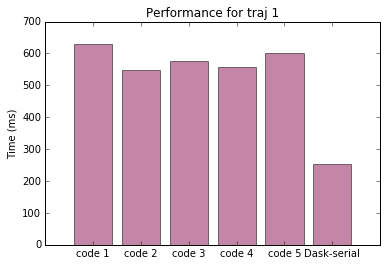

In [21]:
objects = ('code 1', 'code 2', 'code 3', 'code 4', 'code 5', 'Dask-serial')
y_pos = np.arange(len(objects))
performance = [629,548,575,559,600,253]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color='#880E4F')
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Performance for traj 1')

### Dask clusters

Dask can set up clusters for easy parallel calculations. There can be local clusters or clusters for various queuing systems like SUNGRID, SLURRM etc.

In [51]:
from distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

distributed.nanny - WARNING - Worker process still alive after 47 seconds, killing
distributed.nanny - WARNING - Worker process 8003 was killed by signal 15


TimeoutError: Worker failed to start

Client is now a local cluster - it has 8 workers which are the individual cores of the computer

In [23]:
def wrapper_function(delayed_traj):
    nucs = []
    for i in range(len(delayed_traj)):
        nucs.append(delayed_traj[i].compute())
    return nucs

The above function is just used to wrap the delayed object calculation - this is required in order to submit the jobs to local cluster.

In [25]:
del_traj = calculate_nuctraj('traj.light',500)
jobs = client.submit(wrapper_function,del_traj)

In [26]:
jobs

<Future: status: finished, type: list, key: wrapper_function-0303ade79a48f63032d26c2d36825d32>

jobs is Future function - it is not run yet, but scheduled in different clusters available in the system. Nothing is run yet - but everything is planned. A delayed object on future function.

In [27]:
%%timeit
jj = jobs.result()

100 loops, best of 3: 10.9 ms per loop


results function calculated the results now - this ran really fast! of course, because it ran in parallel.

#### Compared to the **10.3 ms** used by the dask code, our python parallel implementation with the same cores took **450 ms**! 

In [31]:
del_traj = calculate_nuctraj('traj.long',500)
jobs = client.submit(wrapper_function,del_traj)

In [34]:
%%timeit
jj = jobs.result()

100 loops, best of 3: 12.1 ms per loop


#### On testing with the longer trajectory, dask took 10.1ms whereas the python implementation took 12 s!

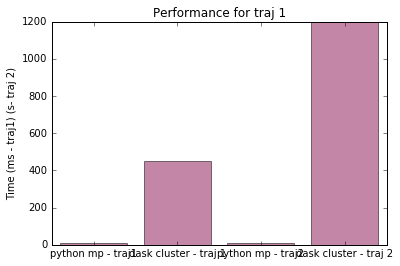

In [36]:
objects = ('python mp - traj1', 'dask cluster - traj 1', 'python mp - traj2', 'dask cluster - traj 2')
y_pos = np.arange(len(objects))
performance = [10,450,12,1200]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color='#880E4F')
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms - traj1) (s- traj 2)')
plt.title('Performance for traj 1')